Importing relevant libraries and packages

In [1]:
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
print("Tensorflow version " + tf.__version__)

from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, SeparableConv2D, BatchNormalization, MaxPool2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg19 import VGG19

Tensorflow version 2.3.0


1. Loading the data and splitting into train, validation and test set

In [2]:
base_path = 'cell_images'
print(os.listdir(base_path))
print(f'Total Parasitized images {len(os.listdir(os.path.join(base_path, "Parasitized")))}')
print(f'Total Uninfected images {len(os.listdir(os.path.join(base_path, "Uninfected")))}')

['Parasitized', 'cell_images', 'Uninfected']
Total Parasitized images 13780
Total Uninfected images 13780


In [3]:
pip install split-folders

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# splitting the data into train, validation and test set
import splitfolders
os.mkdir('images')  # directory to store the Training, Validation and Testing datasets
input_folder = os.path.join(base_path, 'cell_images')
output_folder = 'images'
splitfolders.ratio(input_folder, output=output_folder, seed=10, ratio=(.85, .10, .05), group_prefix=None) # default values

Copying files: 27560 files [01:21, 337.03 files/s]


In [5]:
# checking the newly created directory structure
input_path = 'images'
for folder in os.listdir(input_path):
    print(folder)
    print(os.listdir(os.path.join(input_path, folder)))

val
['Uninfected', 'Parasitized']
test
['Uninfected', 'Parasitized']
train
['Uninfected', 'Parasitized']


In [6]:
train_dir = os.path.join(input_path, 'train')
test_dir = os.path.join(input_path, 'test')
val_dir = os.path.join(input_path, 'val')

train_Parasitized_dir = os.path.join(train_dir, 'Parasitized')
train_Uninfected_dir = os.path.join(train_dir, 'Uninfected')

validation_Parasitized_dir = os.path.join(val_dir, 'Parasitized')
validation_Uninfected_dir = os.path.join(val_dir, 'Uninfected')

test_Parasitized_dir = os.path.join(test_dir, 'Parasitized')
test_Uninfected_dir = os.path.join(test_dir, 'Uninfected')

In [7]:
print('total training Parasitized images :', len(os.listdir(train_Parasitized_dir) ))
print('total training Uninfected images :', len(os.listdir(train_Uninfected_dir) ))

print('total validation Parasitized images :', len(os.listdir(validation_Parasitized_dir) ))
print('total validation Uninfected images :', len(os.listdir(validation_Uninfected_dir) ))

print('total test Parasitized images :', len(os.listdir(test_Parasitized_dir) ))
print('total test Uninfected images :', len(os.listdir(test_Uninfected_dir) ))

total training Parasitized images : 11713
total training Uninfected images : 11713
total validation Parasitized images : 1378
total validation Uninfected images : 1378
total test Parasitized images : 689
total test Uninfected images : 689


2. Data Visualization 

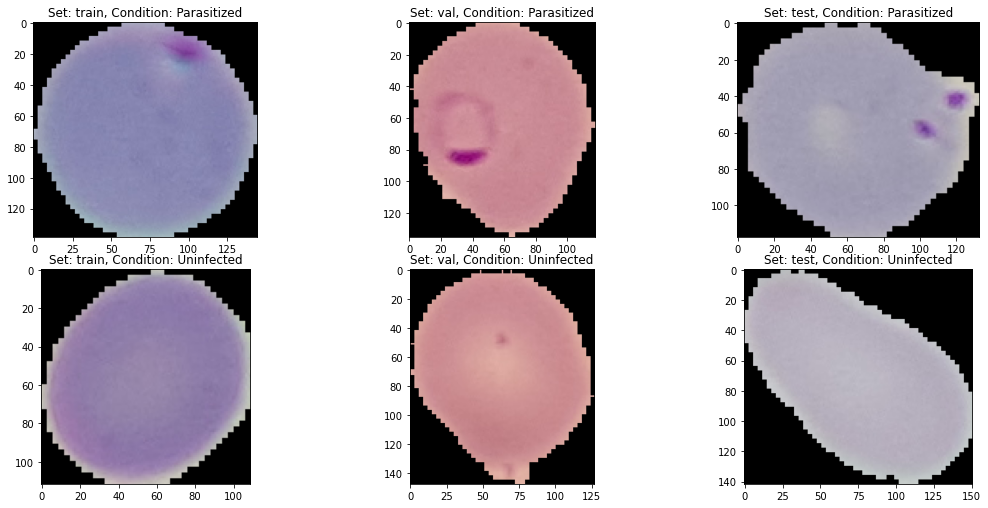

In [8]:
input_path = 'images/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/Parasitized/'+os.listdir(set_path+'/Parasitized')[0]))
    ax[i].set_title('Set: {}, Condition: Parasitized'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/Uninfected/'+os.listdir(set_path+'/Uninfected')[0]))
    ax[i+3].set_title('Set: {}, Condition: Uninfected'.format(_set))

3. Model Building

In [9]:
# defining some fixed parameters
image_shape = [224, 224]
batch_size = 64
epochs = 30

# total number of train and validation images
training_img_count = len(os.listdir(train_Parasitized_dir) ) + len(os.listdir(train_Uninfected_dir) )     
validation_img_count = len(os.listdir(validation_Parasitized_dir) ) + len(os.listdir(validation_Uninfected_dir) )

print(f'total training images: {training_img_count}')
print(f'total training images: {validation_img_count}') 

total training images: 23426
total training images: 2756


In [10]:
# instantiating the VGG19 model
vgg19 = VGG19(input_shape=(image_shape[0], image_shape[1], 3),
                  weights='imagenet', # include the pre-trained weights on ImageNet
                  include_top=False)  # to use our own input and get the desired output

# do not train the existing weights
for layer in vgg19.layers:
  layer.trainable = False

# defining input and output to the model
x = tf.keras.layers.Flatten()(vgg19.output)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs = vgg19.input, outputs = output)

80142336/80134624 [==============================] - 2s 0us/step


4. Data Augmentation and Processing

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (image_shape[0], image_shape[1]),
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    shuffle = True
                                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                  target_size = (image_shape[0], image_shape[1]),
                                                  batch_size = batch_size,
                                                  class_mode = 'binary',
                                                  shuffle = True
                                                 )

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size = (image_shape[0], image_shape[1]),
                                                  batch_size = batch_size,
                                                  class_mode = 'binary',
                                                  shuffle = True)

Found 23424 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Found 1378 images belonging to 2 classes.


5. Model Training

In [12]:
metrics = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
          ]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = metrics)

# stop model training is the validation loss does not decrease for 5 epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=10,
                                              verbose=1,
                                              mode="auto",
                                              restore_best_weights=True
)

# reducing the learning rate every 5 epochs
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='malaria.h5', 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=True,
                                                save_weights_only=False, 
                                                mode='min', 
                                                save_freq='epoch'
)

In [13]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=training_img_count // batch_size,
                    epochs=epochs,
                    validation_steps=validation_img_count // batch_size,
                    callbacks=[early_stop, lr_scheduler, checkpoint],
                    verbose=2
                    )


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.26958, saving model to malaria.h5
366/366 - 70s - loss: 0.3798 - accuracy: 0.8365 - precision: 0.8176 - recall: 0.8662 - val_loss: 0.2696 - val_accuracy: 0.8895 - val_precision: 0.8485 - val_recall: 0.9484

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/30

Epoch 00002: val_loss did not improve from 0.26958
366/366 - 70s - loss: 0.2550 - accuracy: 0.9029 - precision: 0.8830 - recall: 0.9289 - val_loss: 0.3343 - val_accuracy: 0.8547 - val_precision: 0.7787 - val_recall: 0.9913

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/30

Epoch 00003: val_loss improved from 0.26958 to 0.21087, saving model to malaria.h5
366/366 - 70s - loss: 0.2239 - accuracy: 0.9134 - precision: 0.8954 - recall: 0.9362 - val_loss: 0.2109 - val_accuracy: 0.9179 - val_precision: 0.8780 - val_recall: 0.9710

Epoch 00004: LearningRateSc

6. Visualizing model performance

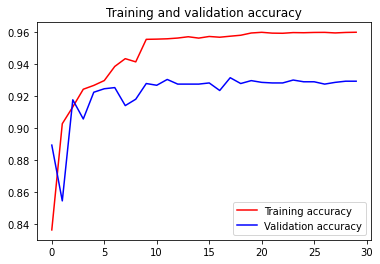

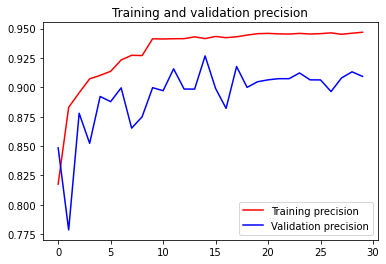

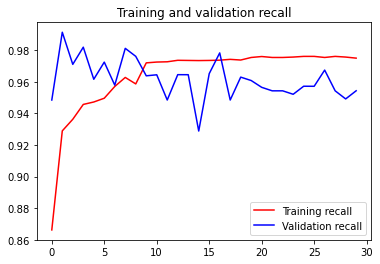

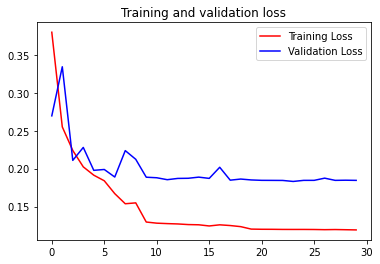

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

epochs = range(len(acc))
plt.figure()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()

plt.figure()

plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

7. Model prediction and evaluation on unseen data

In [15]:
# load the saved model
saved_model = tf.keras.models.load_model('malaria.h5')

In [16]:
model_test_performace = saved_model.evaluate(test_generator)

22/22 [==============================] - 4s 194ms/step - loss: 0.1778 - accuracy: 0.9369 - precision: 0.9251 - recall: 0.9507


In [17]:
test_accuracy = model_test_performace[1]
test_precision = model_test_performace[2]
test_recall = model_test_performace[3]

print(f'Test accuracy: {round(test_accuracy*100, 2)}%')
print(f'Test precision: {round(test_precision*100, 2)}%')
print(f'Test recall: {round(test_recall*100, 2)}%')

Test accuracy: 93.69%
Test precision: 92.51%
Test recall: 95.07%
